<a href="https://colab.research.google.com/github/AhmadMugiar/WEB_SCRAPPING_KP/blob/main/Analisis_Sentimen_Aplikasi_PosAgen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gdown
!pip install Sastrawi
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 12.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import re
import string
import requests
from io import StringIO
import gdown
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [14]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd

In [3]:
data = pd.read_csv('/content/PosAja_Final.csv')
data

,reviewId,userName,rate,reviews_text,tanggal reviews,nama_aplikasi
0,cac942b3-2d1b-4d3d-aa85-1290b35a5a01,pengguna google,5,baik,2025-08-05,PosAja
1,a5f76849-26ea-47bb-b4a6-4471a6036ac3,pengguna google,1,paket saya dikirim ke orang lain tanpa konfirm...,2025-08-03,PosAja
2,9fc42b39-9103-4957-9866-0074b7ccafcc,pengguna google,2,niat hati bikin sim dikirim lewat pos eh malah...,2025-08-02,PosAja
3,284963a3-99db-42fb-9ebf-a3b56d3053bd,pengguna google,1,gila lemot banget pengirimannya,2025-08-01,PosAja
4,20610ea8-98c7-4ac0-b711-fce7e8d051f8,pengguna google,1,"aplikasi rusak. dimasukkan resi pada aplikasi,...",2025-07-30,PosAja
...,...,...,...,...,...,...
6960,1f948e9a-f8e1-4080-8153-41e0cb788b01,pengguna google,5,sangat memudahkan bagi para pelanggan pos dala...,2020-03-05,PosAja
6961,abbc0599-6620-46b0-b8a6-51067e5c2b65,pengguna google,5,perbaiki masalah pin nya orang gampang lupa ti...,2020-03-02,PosAja
6962,b57cb510-9bce-4f88-ad13-d5b9a477951e,pengguna google,5,kembali nya sang legenda...,2020-03-02,PosAja
6963,304143ba-b09a-4fc0-a613-f69ab0661e89,pengguna google,5,lebih maju pos indonesia,2020-03-02,PosAja


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6965 entries, 0 to 6964
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   reviewId         6965 non-null   object
 1   userName         6965 non-null   object
 2   rate             6965 non-null   int64 
 3   reviews_text     6965 non-null   object
 4   tanggal reviews  6965 non-null   object
 5   nama_aplikasi    6965 non-null   object
dtypes: int64(1), object(5)
memory usage: 326.6+ KB


In [7]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [8]:
def cleaningText(text):
    text = re.sub(r'@\w+', '', text)  # Hapus mention
    text = re.sub(r'#\w+', '', text)  # Hapus hashtag
    text = re.sub(r'RT[\s]+', '', text)  # Hapus retweet
    text = re.sub(r'http\S+|www.\S+', '', text)  # Hapus link
    text = re.sub(r'\d+', '', text)  # Hapus angka
    text = re.sub(r'[{}]'.format(re.escape(string.punctuation)), ' ', text)  # Hapus tanda baca
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Menghapus tanda baca dan karakter selain huruf
    text = re.sub(r'(.)\1{1,}', r'\1', text)  # Menangani huruf berulang
    text = re.sub(r'\n', ' ', text)  # Ganti newline dengan spasi
    text = re.sub(r'\s+', ' ', text).strip()  # Menghapus spasi berlebih
    return text

In [9]:
def casefoldingText(text):
    return text.lower()

In [29]:
def load_slang_dictionary(filepath):
    slang_dict = {}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            if ':' in line:
                slang, baku = line.strip().split(':', 1)
                slang_dict[slang.strip()] = baku.strip()
    return slang_dict
slang_dict = load_slang_dictionary('slang.txt')
def normalize_slang(text, slang_dict):
    words = text.split()
    normalized_words = [slang_dict.get(word, word) for word in words]
    return ' '.join(normalized_words)

In [30]:
def tokenizingText(text):
    text = word_tokenize(text)
    return text

In [31]:
import re
from collections import Counter

all_text = " ".join(data['reviews_text'].astype(str))
words = re.findall(r'\b[a-zA-Z]+\b', all_text.lower())
word_freq = Counter(words)
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
slang_template = pd.DataFrame(sorted_words, columns=['slang_word', 'frequency'])
slang_template

,slang_word,frequency
0,pos,1879
1,di,1328
2,sangat,1250
3,dan,1174
4,aplikasi,1101
...,...,...
6642,pemulihannya,1
6643,chattingan,1
6644,nusa,1
6645,pokemon,1


In [32]:
custom_stopwords = set(stopwords.words('indonesian')).union({'dan', 'aplikasi', 'bisa', 'sangat', 'di', 'saya', 'ini', 'agen', 'yang', 'untuk',
    'pospay', 'pulsa', 'nya', 'tidak', 'ada', 'lengkap', 'juga', 'transaksi', 'buat',
    'yg', 'pembayaran', 'saja', 'sudah', 'tapi', 'lah', 'karena', 'jadi', 'sama', 'pada'})

In [33]:
def filteringText(words):
    return [word for word in words if word not in custom_stopwords]

In [34]:
def stemmingText(words):
    return [stemmer.stem(word) for word in words]

In [35]:
def toSentence(list_words):
    return ' '.join(list_words)

In [36]:
data['after_cleaning'] = data['reviews_text'].apply(cleaningText)

In [37]:
data[['reviews_text', 'after_cleaning']]

,reviews_text,after_cleaning
0,baik,baik
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...
...,...,...
6960,sangat memudahkan bagi para pelanggan pos dala...,sangat memudahkan bagi para pelangan pos dalam...
6961,perbaiki masalah pin nya orang gampang lupa ti...,perbaiki masalah pin nya orang gampang lupa ti...
6962,kembali nya sang legenda...,kembali nya sang legenda
6963,lebih maju pos indonesia,lebih maju pos indonesia


In [38]:
data['after_casefolding'] = data['after_cleaning'].apply(casefoldingText)

In [39]:
data[['reviews_text', 'after_cleaning', 'after_casefolding']].head(10)

,reviews_text,after_cleaning,after_casefolding
0,baik,baik,baik
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...


In [40]:
data['after_normalized'] = data['after_casefolding'].apply(lambda x: normalize_slang(x, slang_dict))

In [41]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized']]

,reviews_text,after_cleaning,after_casefolding,after_normalized
0,baik,baik,baik,baik
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh bahka...
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lambat sekali pengirimanya
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...
...,...,...,...,...
6960,sangat memudahkan bagi para pelanggan pos dala...,sangat memudahkan bagi para pelangan pos dalam...,sangat memudahkan bagi para pelangan pos dalam...,sangat memudahkan bagi para pelanggan pos dala...
6961,perbaiki masalah pin nya orang gampang lupa ti...,perbaiki masalah pin nya orang gampang lupa ti...,perbaiki masalah pin nya orang gampang lupa ti...,perbaikan masalah pin nya orang gampang lupa t...
6962,kembali nya sang legenda...,kembali nya sang legenda,kembali nya sang legenda,kembali nya sang legenda
6963,lebih maju pos indonesia,lebih maju pos indonesia,lebih maju pos indonesia,lebih maju pos indonesia


In [42]:
data['after_tokenizing'] = data['after_normalized'].apply(tokenizingText)

In [43]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing
0,baik,baik,baik,baik,[baik]
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,"[paket, saya, dikirim, ke, orang, lain, tanpa,..."
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh bahka...,"[niat, hati, bikin, sim, dikirim, lewat, pos, ..."
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lambat sekali pengirimanya,"[gila, lambat, sekali, pengirimanya]"
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,"[aplikasi, rusak, dimasukan, resi, pada, aplik..."
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,whatsapp tolong dicantumkan per daerah biar je...,"[whatsapp, tolong, dicantumkan, per, daerah, b..."
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,tidak whatsapp tolong cantumkan biar jelas pem...,"[tidak, whatsapp, tolong, cantumkan, biar, jel..."
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...,mengirim paket kok berhari hari padahal sudah ...,"[mengirim, paket, kok, berhari, hari, padahal,..."
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih,sangat membantu terima ksih,"[sangat, membantu, terima, ksih]"
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang dari...,"[sangat, bermanfat, membantu, sekali, pedagang..."


In [44]:
data['after_filtering'] = data['after_tokenizing'].apply(filteringText)

In [45]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering
0,baik,baik,baik,baik,[baik],[]
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,"[paket, saya, dikirim, ke, orang, lain, tanpa,...","[paket, dikirim, orang, konfirmasi, status, pa..."
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh bahka...,"[niat, hati, bikin, sim, dikirim, lewat, pos, ...","[niat, hati, bikin, sim, dikirim, pos, eh, nih..."
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lambat sekali pengirimanya,"[gila, lambat, sekali, pengirimanya]","[gila, lambat, pengirimanya]"
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,"[aplikasi, rusak, dimasukan, resi, pada, aplik...","[rusak, dimasukan, resi, data, valid, lacak, m..."
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,whatsapp tolong dicantumkan per daerah biar je...,"[whatsapp, tolong, dicantumkan, per, daerah, b...","[whatsapp, tolong, dicantumkan, daerah, biar, ..."
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,tidak whatsapp tolong cantumkan biar jelas pem...,"[tidak, whatsapp, tolong, cantumkan, biar, jel...","[whatsapp, tolong, cantumkan, biar, pemesanan,..."
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...,mengirim paket kok berhari hari padahal sudah ...,"[mengirim, paket, kok, berhari, hari, padahal,...","[mengirim, paket, berhari, banget, tinggal, al..."
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih,sangat membantu terima ksih,"[sangat, membantu, terima, ksih]","[membantu, terima, ksih]"
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang dari...,"[sangat, bermanfat, membantu, sekali, pedagang...","[bermanfat, membantu, pedagang, daring, pengir..."


In [46]:
data['after_stemming'] = data['after_filtering'].apply(stemmingText)

In [ ]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering', 'after_stemming']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering,after_stemming
0,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,aplikasi pembayaran terbaik,"[aplikasi, pembayaran, terbaik]",[terbaik],[baik]
1,ok,ok,ok,oke,[oke],[oke],[oke]
2,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah kan informasi cepat tepat kepada masya...,memudah akan informasi cepat tepat kepada masy...,"[memudah, akan, informasi, cepat, tepat, kepad...","[memudah, informasi, cepat, masyarakat]","[mudah, informasi, cepat, masyarakat]"
3,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus]
4,sangat membantu,sangat membantu,sangat membantu,sangat membantu,"[sangat, membantu]",[membantu],[bantu]
5,bagus,bagus,bagus,bagus,[bagus],[bagus],[bagus]
6,super,super,super,sangat,[sangat],[],[]
7,terimakasih,terimakasih,terimakasih,terima kasih,"[terima, kasih]","[terima, kasih]","[terima, kasih]"
8,belom ada notif pembaruan,belom ada notif pembaruan,belom ada notif pembaruan,belum ada notif pembaruan,"[belum, ada, notif, pembaruan]","[notif, pembaruan]","[notif, baru]"
9,gak jelas,gak jelas,gak jelas,tidak jelas,"[tidak, jelas]",[],[]


In [47]:
data['final_sentence'] = data['after_stemming'].apply(toSentence)

In [48]:
data[['reviews_text', 'after_cleaning', 'after_casefolding', 'after_normalized', 'after_tokenizing', 'after_filtering', 'after_stemming', 'final_sentence']].head(10)

,reviews_text,after_cleaning,after_casefolding,after_normalized,after_tokenizing,after_filtering,after_stemming,final_sentence
0,baik,baik,baik,baik,[baik],[],[],
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,"[paket, saya, dikirim, ke, orang, lain, tanpa,...","[paket, dikirim, orang, konfirmasi, status, pa...","[paket, kirim, orang, konfirmasi, status, pake...",paket kirim orang konfirmasi status paket teri...
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh bahka...,"[niat, hati, bikin, sim, dikirim, lewat, pos, ...","[niat, hati, bikin, sim, dikirim, pos, eh, nih...","[niat, hati, bikin, sim, kirim, pos, eh, nihil...",niat hati bikin sim kirim pos eh nihil harus t...
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lemot banget pengirimanya,gila lambat sekali pengirimanya,"[gila, lambat, sekali, pengirimanya]","[gila, lambat, pengirimanya]","[gila, lambat, pengirimanya]",gila lambat pengirimanya
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...,"[aplikasi, rusak, dimasukan, resi, pada, aplik...","[rusak, dimasukan, resi, data, valid, lacak, m...","[rusak, masuk, resi, data, valid, lacak, mengu...",rusak masuk resi data valid lacak mengunakan w...
5,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,wa tolong dicantumkan per daerah biar jelas pe...,whatsapp tolong dicantumkan per daerah biar je...,"[whatsapp, tolong, dicantumkan, per, daerah, b...","[whatsapp, tolong, dicantumkan, daerah, biar, ...","[whatsapp, tolong, cantum, daerah, biar, mesan...",whatsapp tolong cantum daerah biar mesan konsu...
6,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,no wa tolong cantumkan biar jelas pemesanan ko...,tidak whatsapp tolong cantumkan biar jelas pem...,"[tidak, whatsapp, tolong, cantumkan, biar, jel...","[whatsapp, tolong, cantumkan, biar, pemesanan,...","[whatsapp, tolong, cantum, biar, mesan, konsum...",whatsapp tolong cantum biar mesan konsumen rug...
7,ngirim pakett kok berhari hari. padahal udah d...,ngirim paket kok berhari hari padahal udah dek...,ngirim paket kok berhari hari padahal udah dek...,mengirim paket kok berhari hari padahal sudah ...,"[mengirim, paket, kok, berhari, hari, padahal,...","[mengirim, paket, berhari, banget, tinggal, al...","[kirim, paket, hari, banget, tinggal, alamat, ...",kirim paket hari banget tinggal alamat terima ...
8,sangat membantu.. trima ksih 🙏,sangat membantu trima ksih,sangat membantu trima ksih,sangat membantu terima ksih,"[sangat, membantu, terima, ksih]","[membantu, terima, ksih]","[bantu, terima, ksih]",bantu terima ksih
9,sangat bermanfaat. membantu sekali pedagang on...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang onli...,sangat bermanfat membantu sekali pedagang dari...,"[sangat, bermanfat, membantu, sekali, pedagang...","[bermanfat, membantu, pedagang, daring, pengir...","[bermanfat, bantu, dagang, daring, kirim, indo...",bermanfat bantu dagang daring kirim indonesia ...


In [49]:
!gdown --id 1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1hOYYAYMGSd0JoqDcBxjhtVm6koOnk-KQ
To: /content/lexicon_positive_ver1.csv
100% 41.4k/41.4k [00:00<00:00, 75.4MB/s]


In [50]:
!gdown --id 1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1HVydsM-fsSdIugnuSF6L9-Ai4UnRB_ju
To: /content/lexicon_negative_ver1.csv
100% 82.8k/82.8k [00:00<00:00, 17.7MB/s]


In [51]:
lexicon_positive = dict()
import csv
with open('lexicon_positive_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
import csv
with open('lexicon_negative_ver1.csv', 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    lexicon_negative[row[0]] = int(row[1])

In [52]:
def sentimen_lexicon_indo(text):
  score = 0
  for word_pos in text:
    if (word_pos in lexicon_positive):
      score = score + lexicon_positive[word_pos]
  for word_neg in text:
    if (word_neg in lexicon_negative):
      score = score + lexicon_negative[word_neg]
  polarity=''
  if (score > 0):
    polarity = 'positif'
  elif (score < 0):
    polarity = 'negatif'
  else:
    polarity = 'netral'

  return score, polarity

In [88]:
string = "pospay"
string = string.split()
hasil = sentimen_lexicon_indo(string)
hasil

(-3, 'negatif')

In [54]:
data['tokenized'] = data['final_sentence'].apply(lambda x: x.split())

In [55]:
data[['score', 'sentiment']] = data['tokenized'].apply(lambda x: pd.Series(sentimen_lexicon_indo(x)))

In [56]:
results = data['tokenized'].apply(sentimen_lexicon_indo)
results = list(zip(*results))
data['polarity_score'] = results[0]
data['polarity'] = results[1]
print(data['polarity'].value_counts())

polarity
positif    3744
negatif    2042
netral     1179
Name: count, dtype: int64


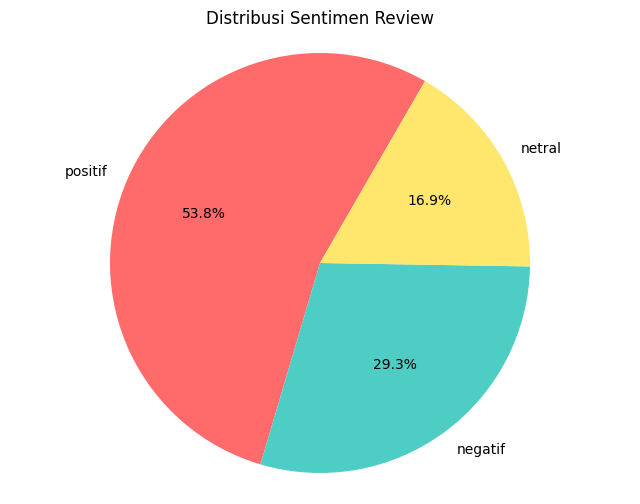

In [57]:
# Hitung jumlah masing-masing sentimen
sentiment_counts = data['polarity'].value_counts()

# Label dan nilai
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = ['#FF6B6B', '#4ECDC4', '#FFE66D']

# Buat pie chart
plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=60, colors=colors)
plt.title('Distribusi Sentimen Review')
plt.axis('equal')  # Membuat pie-nya jadi lingkaran sempurna
plt.show()

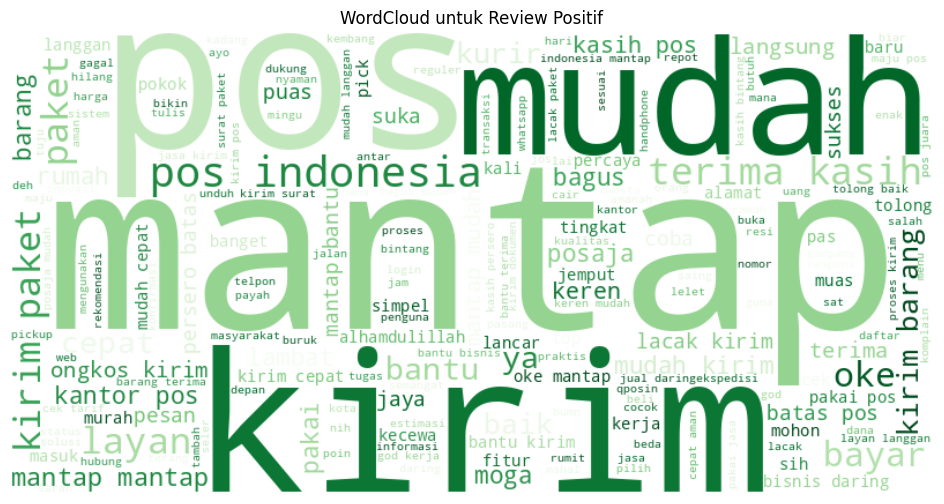

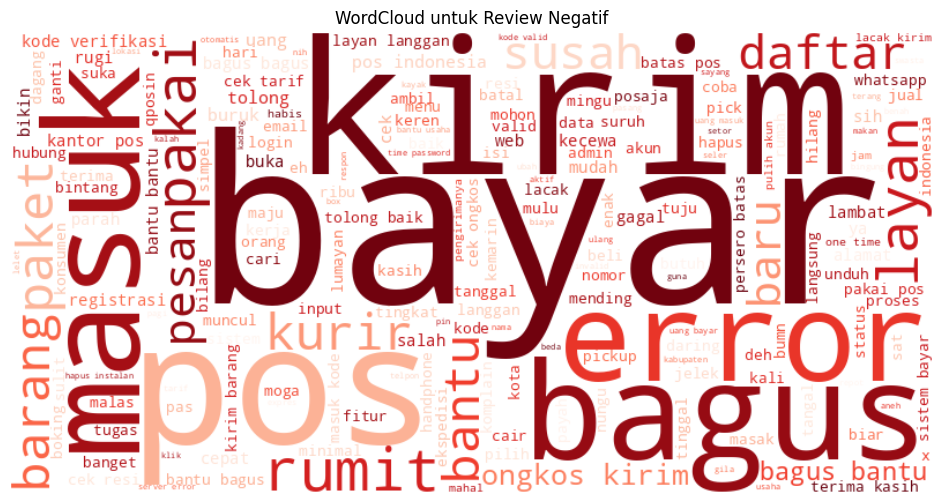

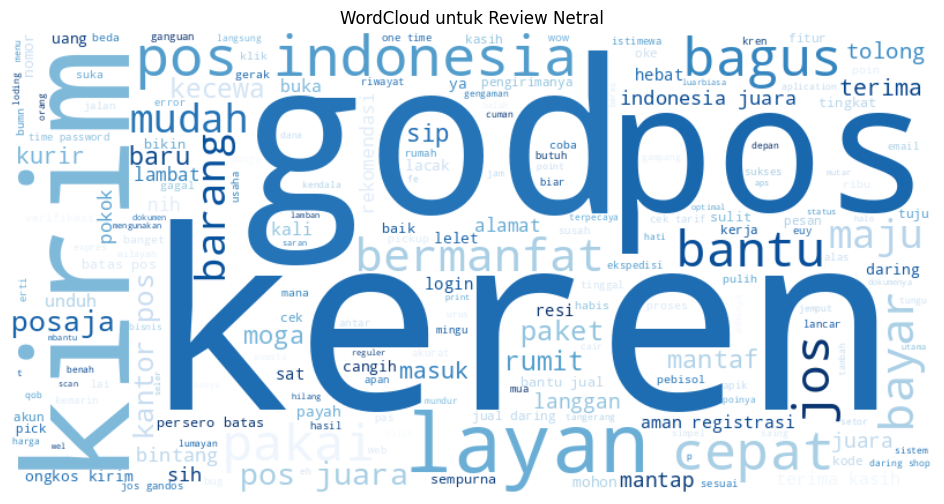

In [58]:
# Fungsi untuk membuat dan menampilkan WordCloud
def tampilkan_wordcloud(text, title, colormap):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=colormap).generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Gabungkan semua teks dari tiap sentimen
positif_text = ' '.join(data[data['polarity'] == 'positif']['final_sentence'])
negatif_text = ' '.join(data[data['polarity'] == 'negatif']['final_sentence'])
netral_text  = ' '.join(data[data['polarity'] == 'netral']['final_sentence'])

# Tampilkan WordCloud
tampilkan_wordcloud(positif_text, 'WordCloud untuk Review Positif', 'Greens')
tampilkan_wordcloud(negatif_text, 'WordCloud untuk Review Negatif', 'Reds')
tampilkan_wordcloud(netral_text,  'WordCloud untuk Review Netral',  'Blues')

In [64]:
X = data['final_sentence']
y = data['polarity']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)

(5572,)
(1393,)


In [66]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

In [67]:
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

In [68]:
# Membuat objek model SVM
svm_model = SVC(C=1, kernel='rbf')

# Melatih model SVM pada data pelatihan
svm_model.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_svm = svm_model.predict(X_train.toarray())
y_pred_test_svm = svm_model.predict(X_test.toarray())

# Evaluasi akurasi model SVM
accuracy_train_svm = accuracy_score(y_pred_train_svm, y_train)
accuracy_test_svm = accuracy_score(y_pred_test_svm, y_test)

# Menampilkan akurasi
print('SVM - accuracy_train:', accuracy_train_svm)
print('SVM - accuracy_test:', accuracy_test_svm)

SVM - accuracy_train: 0.9854630294328787
SVM - accuracy_test: 0.9045226130653267


In [69]:
# Menampilkan classification report
print('\nClassification Report SVM (Test Data):')
print(classification_report(y_test, y_pred_test_svm))


Classification Report SVM (Test Data):
              precision    recall  f1-score   support

     negatif       0.89      0.89      0.89       413
      netral       0.95      0.73      0.82       241
     positif       0.90      0.97      0.93       739

    accuracy                           0.90      1393
   macro avg       0.91      0.86      0.88      1393
weighted avg       0.91      0.90      0.90      1393



In [70]:
# Membuat objek model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Melatih model Random Forest pada data pelatihan
rf_model.fit(X_train.toarray(), y_train)

# Prediksi sentimen pada data pelatihan dan data uji
y_pred_train_rf = rf_model.predict(X_train.toarray())
y_pred_test_rf = rf_model.predict(X_test.toarray())

# Evaluasi akurasi model Random Forest
accuracy_train_rf = accuracy_score(y_train, y_pred_train_rf)
accuracy_test_rf = accuracy_score(y_test, y_pred_test_rf)

# Menampilkan akurasi
print('Random Forest - accuracy_train:', accuracy_train_rf)
print('Random Forest - accuracy_test:', accuracy_test_rf)

Random Forest - accuracy_train: 1.0
Random Forest - accuracy_test: 0.8844221105527639


In [75]:
# Menampilkan classification report
print('\nClassification Report Random Forest (Test Data):')
print(classification_report(y_test, y_pred_test_rf))


Classification Report Random Forest (Test Data):
              precision    recall  f1-score   support

     negatif       0.89      0.81      0.85       413
      netral       0.83      0.83      0.83       241
     positif       0.90      0.94      0.92       739

    accuracy                           0.88      1393
   macro avg       0.87      0.86      0.87      1393
weighted avg       0.88      0.88      0.88      1393



In [76]:
X = data['final_sentence']
y = data['polarity']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

print(X_train.shape)
print(X_test.shape)

(5572,)
(1393,)


In [78]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post')

In [79]:
# Label Encoding

encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_test_cat = to_categorical(y_test_enc)

In [80]:
# Custom Callback
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

In [81]:
# modeling dengan lstm
model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
        Bidirectional(LSTM(128, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_pad, y_train_cat, epochs=15, batch_size=32,
                        validation_data=(X_test_pad, y_test_cat), callbacks=[early_stop, reduce_lr])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 65s 344ms/step - accuracy: 0.5869 - loss: 0.8952 - val_accuracy: 0.8973 - val_loss: 0.3195 - learning_rate: 0.0010
Epoch 2/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 57s 329ms/step - accuracy: 0.9221 - loss: 0.2558 - val_accuracy: 0.9139 - val_loss: 0.2582 - learning_rate: 0.0010
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 60s 341ms/step - accuracy: 0.9528 - loss: 0.1461 - val_accuracy: 0.9131 - val_loss: 0.2767 - learning_rate: 0.0010
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 340ms/step - accuracy: 0.9644 - loss: 0.1090 - val_accuracy: 0.9045 - val_loss: 0.3333 - learning_rate: 0.0010
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 339ms/step - accuracy: 0.9652 - loss: 0.0984 - val_accuracy: 0.9067 - val_loss: 0.3372 - learning_rate: 0.0010
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 82s 339ms/step - accuracy: 0.9740 - loss: 0.0770 - val_accuracy: 0.9074 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.97

In [82]:
# Evaluasi akurasi pada data training
train_pred_probs = model.predict(X_train_pad)
train_pred = np.argmax(train_pred_probs, axis=1)
train_true = np.argmax(y_train_cat, axis=1)
accuracy_train_lstm = accuracy_score(train_true, train_pred)

# Evaluasi akurasi pada data testing
test_pred_probs = model.predict(X_test_pad)
test_pred = np.argmax(test_pred_probs, axis=1)
test_true = np.argmax(y_test_cat, axis=1)
accuracy_test_lstm = accuracy_score(test_true, test_pred)

# Menampilkan hasil evaluasi
print('LSTM - accuracy_train:', accuracy_train_lstm)
print('LSTM - accuracy_test:', accuracy_test_lstm)

175/175 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step
LSTM - accuracy_train: 0.9536970567121321
LSTM - accuracy_test: 0.9138549892318737


In [83]:
# Classification report
print("\nClassification Report Bidirectional LSTM (Test Data):")
print(classification_report(test_true, test_pred, target_names=encoder.classes_))


Classification Report Bidirectional LSTM (Test Data):
              precision    recall  f1-score   support

     negatif       0.87      0.91      0.89       413
      netral       0.91      0.81      0.86       241
     positif       0.94      0.95      0.94       739

    accuracy                           0.91      1393
   macro avg       0.91      0.89      0.90      1393
weighted avg       0.91      0.91      0.91      1393



In [84]:
data['after_normalized'] = data['after_casefolding'].apply(lambda x: normalize_slang(x, slang_dict))
print("Kolom 'after_normalized' berhasil dibuat dengan normalisasi slang.")
display(data[['reviews_text', 'after_casefolding', 'after_normalized']].head())

Kolom 'after_normalized' berhasil dibuat dengan normalisasi slang.


,reviews_text,after_casefolding,after_normalized
0,baik,baik,baik
1,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...,paket saya dikirim ke orang lain tanpa konfirm...
2,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh malah...,niat hati bikin sim dikirim lewat pos eh bahka...
3,gila lemot banget pengirimannya,gila lemot banget pengirimanya,gila lambat sekali pengirimanya
4,"aplikasi rusak. dimasukkan resi pada aplikasi,...",aplikasi rusak dimasukan resi pada aplikasi da...,aplikasi rusak dimasukan resi pada aplikasi da...
